# ERA5 Comparison

In [ ]:
# general
import datetime as dt
import glob
# data 
import xarray as xr 
import numpy as np
import pandas as pd
# plotting
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mpl_toolkits.basemap import Basemap
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from PIL import Image
from matplotlib.animation import PillowWriter, FFMpegWriter
# helper tools
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()
# stats
import seaborn as sns
import shapely.geometry as shp
from itertools import product
from scipy.stats import pearsonr, spearmanr
# machine learning
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score, f1_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# Functions

In [2]:
def calc_valley_aligned_wind_speed(wind_speed, wind_dir, valley_alignment):
    """
    Calculate the valley aligned wind speed
    """
    # calculate the angle between the wind direction and the valley alignment
    angle = np.abs(wind_dir - valley_alignment)
    # calculate the valley aligned wind speed
    valley_aligned_wind_speed = wind_speed * np.cos(np.radians(angle))
    return valley_aligned_wind_speed

def subset_ds(ds, winter_slice, location, cross_valley_orientation, valley_orientation):
    """
    Subset the dataset to the winter months
    """
    # subset the data   
    ds_subset = ds.sel(valid_time=winter_slice)
    if location is None:
        ds_subset = ds_subset.mean(dim=['latitude', 'longitude']).compute()
    else:
        ds_subset = ds_subset.sel(latitude=location.y, longitude=location.x, method='nearest').compute()

    # calculate the wind speed and direction
    ds_subset['wind_speed'] = np.sqrt(ds_subset.u**2 + ds_subset.v**2)
    # create a column with the wind direction
    ds_subset['wind_dir'] = np.arctan2(ds_subset['v'], ds_subset['u']) * 180 / np.pi
    # convert wind direction to compass direction
    ds_subset['wind_dir'] = (270 - ds_subset['wind_dir']) % 360
    ds_subset['valley_component_wind_speed'] = np.abs(calc_valley_aligned_wind_speed(ds_subset['wind_speed'], ds_subset['wind_dir'], valley_orientation))
    ds_subset['cross_valley_component_wind_speed'] = np.abs(calc_valley_aligned_wind_speed(ds_subset['wind_speed'], ds_subset['wind_dir'], cross_valley_orientation))
    # calculate dew point from relative humidity and temeprature
    # convert temperature to celsius
    ds_subset['t'] = units.units('degC') * (ds_subset['t']-273.15)
    return ds_subset

def select_data(lh_df, ppt_data, reanalysis_ds, short_events, long_events):
    """
    This function will provide the necessary data for the analysis of sublimation events in relation to the reanalysis data.
    """
    # resample latent heat flux data and precipitation data to 3H
    lh_df_3H = lh_df.resample('3H').mean()
    ppt_data_3H = ppt_data.resample('3H').sum()
    #   filter out exrtreme values
    lh_df_3H = lh_df_3H.where(lh_df_3H >-50, np.nan)
    # select the reanalysis pressure level
    ds = reanalysis_ds.sel(pressure_level=500).resample(valid_time='3H').mean()

    return lh_df_3H, ppt_data_3H, ds, short_events, long_events


In [3]:


def find_best_synoptic_variable(surface_obs, synoptic_data, method='pearson'):
    """
    Finds the synoptic-scale variable that is most closely related to a given surface meteorology observation.

    Parameters:
    - surface_obs (pd.Series): Time series of the surface meteorology variable (e.g., temperature, humidity).
    - synoptic_data (pd.DataFrame): Time series of synoptic-scale variables (e.g., geopotential height, wind speed).
    - method (str): Correlation method ('pearson' for linear, 'spearman' for rank-based). Default is 'pearson'.

    Returns:
    - dict: Contains the best-correlated variable, its correlation coefficient, and the full correlation results.
    """
    
    correlations = {}

    for var in synoptic_data.columns:
        synoptic_var = synoptic_data[var]

        # Drop NaN values
        valid_idx = surface_obs.index.intersection(synoptic_var.dropna().index)
        x = surface_obs.loc[valid_idx]
        y = synoptic_var.loc[valid_idx]

        if len(x) < 10:  # Require a minimum number of valid data points
            continue

        # Compute correlation
        if method == 'pearson':
            corr, _ = pearsonr(x, y)
        elif method == 'spearman':
            corr, _ = spearmanr(x, y)
        else:
            raise ValueError("Invalid method. Choose 'pearson' or 'spearman'.")

        correlations[var] = corr

    # Find the variable with the highest absolute correlation
    best_var = max(correlations, key=lambda k: abs(correlations[k]))
    
    return {
        'best_variable': best_var,
        'best_correlation': correlations[best_var],
        'all_correlations': correlations
    }


In [4]:
def gridsearch_optimal_thresholds(era5_ds, long_events, ppt_data, quantile_range=np.arange(0.05, 0.96, 0.05), metric='f1'):
    """
    Perform a grid search to find the optimal thresholds for wind speed, specific humidity, and temperature 
    based on confusion matrix performance, ensuring TP > 40.

    Parameters:
    - era5_ds (xarray.Dataset): Dataset containing wind speed ('wind_speed'), specific humidity ('q'), and temperature ('t').
    - long_events (pandas.DataFrame or Index): Time indices of large events.
    - ppt_data (pandas.Series or np.array): Precipitation data to filter events (0 means no precipitation).
    - quantile_range (array-like): List of quantiles to test for each variable.
    - metric (str): Performance metric to optimize ('accuracy', 'precision', 'recall', 'f1').

    Returns:
    - dict: Best thresholds and corresponding confusion matrix.
    """
    
    best_score = -np.inf
    best_thresholds = None
    best_conf_matrix = None

    # Generate all combinations of quantiles
    for wind_q, spec_hum_q, temp_q in product(quantile_range, repeat=3):
        
        # Set thresholds
        wind_threshold = era5_ds['wind_speed'].quantile(wind_q)
        spec_hum_threshold = era5_ds['q'].quantile(spec_hum_q)
        temp_threshold = era5_ds['t'].quantile(temp_q)

        # when event occurs and threshold is high: True positive
        true_positive = ((era5_ds.sel(valid_time=long_events.index)['wind_speed'] >= wind_threshold) |
                                            (era5_ds.sel(valid_time=long_events.index)['q'] <= spec_hum_threshold) |
                                            (era5_ds.sel(valid_time=long_events.index)['t'] >= temp_threshold)).sum().item()
        # when non-event occurs and threshold is high: false positive
        false_positive = ((era5_ds.drop_sel(valid_time=long_events.index)['wind_speed'] >= wind_threshold) |
                                            (era5_ds.drop_sel(valid_time=long_events.index)['q'] <= spec_hum_threshold) |
                                            (era5_ds.drop_sel(valid_time=long_events.index)['t'] >= temp_threshold)).sum().item()

        # when event occurs and threshold is low: false negative
        false_negative = ((era5_ds.sel(valid_time=long_events.index)['wind_speed'] < wind_threshold) |
                                            (era5_ds.sel(valid_time=long_events.index)['q'] > spec_hum_threshold) |
                                            (era5_ds.sel(valid_time=long_events.index)['t'] < temp_threshold)).sum().item()

        # when non-event occurs and threshold is low: true negative
        true_negative = ((era5_ds.drop_sel(valid_time=long_events.index)['wind_speed'] < wind_threshold) |
                                            (era5_ds.drop_sel(valid_time=long_events.index)['q'] > spec_hum_threshold) |
                                            (era5_ds.drop_sel(valid_time=long_events.index)['t'] < temp_threshold)).sum().item()
        
        # high_valus_during_large_events = long_events.where(high_vals)

        # Compute confusion matrix values
        TP = true_positive
        FP = false_positive
        FN = false_negative
        TN = true_negative

        # Ensure TP > 40
        if TP <= 40:
            continue  # Skip this iteration if TP is too low

        # Store in DataFrame
        conf_matrix = pd.DataFrame({'Event': [TP, FN], 'Non-Event': [FP, TN]},
                                   index=['High Wind Speed', 'Low Wind Speed'])

        # Compute metric
        if metric == 'accuracy':
            score = (TP + TN) / (TP + TN + FP + FN)
        elif metric == 'precision':
            score = TP / (TP + FP) if (TP + FP) > 0 else 0
        elif metric == 'recall':
            score = TP / (TP + FN) if (TP + FN) > 0 else 0
        elif metric == 'f1':
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        else:
            raise ValueError("Invalid metric. Choose from 'accuracy', 'precision', 'recall', 'f1'.")

        # Update best result
        if score > best_score:
            best_score = score
            best_thresholds = {'wind': wind_q, 'specific_humidity': spec_hum_q, 'temperature': temp_q}
            best_conf_matrix = conf_matrix.copy()

    return {
        'best_thresholds': best_thresholds,
        'best_confusion_matrix': best_conf_matrix,
        'best_score': best_score
    }


In [5]:

def gridsearch_optimal_thresholds(era5_ds, long_events, ppt_data, quantile_range=np.arange(0.05, 0.96, 0.05), metric='f1'):
    """
    Perform a grid search to find the optimal thresholds for wind speed, specific humidity, and temperature 
    based on confusion matrix performance, ensuring TP > 40.

    Parameters:
    - era5_ds (xarray.Dataset): Dataset containing wind speed ('wind_speed'), specific humidity ('q'), and temperature ('t').
    - long_events (pandas.DataFrame or Index): Time indices of large events.
    - ppt_data (pandas.Series or np.array): Precipitation data to filter events (0 means no precipitation).
    - quantile_range (array-like): List of quantiles to test for each variable.
    - metric (str): Performance metric to optimize ('accuracy', 'precision', 'recall', 'f1').

    Returns:
    - dict: Best thresholds and corresponding confusion matrix.
    """
    
    best_score = -np.inf
    best_thresholds = None
    best_conf_matrix = None

    # Generate all combinations of quantiles
    for wind_q, spec_hum_q, temp_q in product(quantile_range, repeat=3):
        
        # Set thresholds
        wind_threshold = era5_ds['wind_speed'].quantile(wind_q)
        spec_hum_threshold = era5_ds['q'].quantile(spec_hum_q)
        temp_threshold = era5_ds['t'].quantile(temp_q)

        # when event occurs and threshold is high: True positive
        true_positive = ((era5_ds.sel(valid_time=long_events.index)['wind_speed'] >= wind_threshold) |
                                            (era5_ds.sel(valid_time=long_events.index)['q'] <= spec_hum_threshold) |
                                            (era5_ds.sel(valid_time=long_events.index)['t'] >= temp_threshold)).sum().item()
        # when non-event occurs and threshold is high: false positive
        false_positive = ((era5_ds.drop_sel(valid_time=long_events.index)['wind_speed'] >= wind_threshold) |
                                            (era5_ds.drop_sel(valid_time=long_events.index)['q'] <= spec_hum_threshold) |
                                            (era5_ds.drop_sel(valid_time=long_events.index)['t'] >= temp_threshold)).sum().item()

        # when event occurs and threshold is low: false negative
        false_negative = ((era5_ds.sel(valid_time=long_events.index)['wind_speed'] < wind_threshold) |
                                            (era5_ds.sel(valid_time=long_events.index)['q'] > spec_hum_threshold) |
                                            (era5_ds.sel(valid_time=long_events.index)['t'] < temp_threshold)).sum().item()

        # when non-event occurs and threshold is low: true negative
        true_negative = ((era5_ds.drop_sel(valid_time=long_events.index)['wind_speed'] < wind_threshold) |
                                            (era5_ds.drop_sel(valid_time=long_events.index)['q'] > spec_hum_threshold) |
                                            (era5_ds.drop_sel(valid_time=long_events.index)['t'] < temp_threshold)).sum().item()
        
        # high_valus_during_large_events = long_events.where(high_vals)

        # Compute confusion matrix values
        TP = true_positive
        FP = false_positive
        FN = false_negative
        TN = true_negative

        # Ensure TP > 40
        if TP <= 40:
            continue  # Skip this iteration if TP is too low

        # Store in DataFrame
        conf_matrix = pd.DataFrame({'Event': [TP, FN], 'Non-Event': [FP, TN]},
                                   index=['High Wind Speed', 'Low Wind Speed'])

        # Compute metric
        if metric == 'accuracy':
            score = (TP + TN) / (TP + TN + FP + FN)
        elif metric == 'precision':
            score = TP / (TP + FP) if (TP + FP) > 0 else 0
        elif metric == 'recall':
            score = TP / (TP + FN) if (TP + FN) > 0 else 0
        elif metric == 'f1':
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        else:
            raise ValueError("Invalid metric. Choose from 'accuracy', 'precision', 'recall', 'f1'.")

        # Update best result
        if score > best_score:
            best_score = score
            best_thresholds = {'wind': wind_q, 'specific_humidity': spec_hum_q, 'temperature': temp_q}
            best_conf_matrix = conf_matrix.copy()

    return {
        'best_thresholds': best_thresholds,
        'best_confusion_matrix': best_conf_matrix,
        'best_score': best_score
    }


In [6]:
def compute_cross_correlation(df, target_var, lag_range=(-10, 10)):
    """
    Compute cross-correlations between a target variable and other variables with different time lags.

    Parameters:
    - df: pandas DataFrame with time-indexed meteorological variables.
    - target_var: Name of the target variable (e.g., "sublimation").
    - lag_range: Tuple specifying min and max lag (e.g., (-10, 10)).

    Returns:
    - A DataFrame containing cross-correlations for each lag.
    """
    variables = df.columns.drop(target_var)  # Exclude the target variable itself
    lag_values = range(lag_range[0], lag_range[1] + 1)

    correlation_results = pd.DataFrame(index=lag_values, columns=variables)

    for lag in lag_values:
        shifted_target = df[target_var].shift(lag)  # Shift target variable
        correlation_results.loc[lag] = df[variables].corrwith(shifted_target)

    return correlation_results.astype(float)

In [7]:
# Plotting 
def plot_surface_and_reanalysis_vars(lh_df, ppt_data, era5_ds, short_events, long_events, lh_var, reanalysis_var1, reanalysis_var2):
    """
    This function will plot the relationship between the latent heat flux and the reanalysis variables.
    Inputs:
    lh_df: DataFrame with the latent heat flux data
    ppt_data: DataFrame with the precipitation data
    era5_ds: xarray dataset with the reanalysis data
    short_events: DataFrame with the short, intense sublimation events
    long_events: DataFrame with the long sublimation events
    lh_var: string with the name of the latent heat flux variable
    reanalysis_var1: string with the name of the first reanalysis variable
    reanalysis_var2: string with the name of the second reanalysis variable
    """
    lh_df, ppt_data, era5_ds, short_events, long_events = select_data(lh_df, ppt_data, era5_ds, short_events, long_events)

    xlabel_dict = {'u': 'Wind Speed (m/s)', 
                   'v': 'Wind Speed (m/s)', 
                   't': 'Temperature (C)', 
                   'q': 'Specifc Humidity (kg/kg)', 
                   'wind_speed': 'Wind Speed (m/s)', 
                   'wind_dir': 'Wind Direction (degrees)',
                   'valley_component_wind_speed': 'Valley Component Wind Speed (m/s)',
                   'cross_valley_component_wind_speed': 'Cross Valley Component Wind Speed (m/s)',}
    xlims_dict = {
             'q': (0, 0.0035),
             't': (-40, -5),}
             
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    ax = axs[0]
    ax.scatter(era5_ds[reanalysis_var1], lh_df[lh_var])
    # ax.set_xlabel('Wind Speed')
    ax.set_ylabel('Daily Average Latent Heat Flux (W/m^2)')
    if reanalysis_var1 in xlims_dict.keys():
            ax.set_xlim(xlims_dict[reanalysis_var1])

    # add edge color around the large sublimation events 
    ax.scatter(era5_ds.sel(valid_time=long_events.index)[reanalysis_var1], lh_df.loc[long_events.index][lh_var], c="black", edgecolors='black')
    ax.scatter(era5_ds.sel(valid_time=ppt_data[ppt_data>1].index)[reanalysis_var1], lh_df.loc[ppt_data[ppt_data>1].index][lh_var], c="red", edgecolors='red', label='Precipitation')
    ax.set_xlabel(xlabel_dict[reanalysis_var1])
    ax.axvline(28, color='black', linestyle='--')
    
    ax = axs[1]
    ax.scatter(era5_ds[reanalysis_var2], lh_df[lh_var])
    ax.scatter(era5_ds.sel(valid_time=long_events.index)[reanalysis_var2], lh_df.loc[long_events.index][lh_var], c="black", edgecolors='black', label='Long Events')
    ax.axvline(33, color='black', linestyle='--')
    ax.scatter(era5_ds.sel(valid_time=ppt_data[ppt_data>1].index)[reanalysis_var2], lh_df.loc[ppt_data[ppt_data>1].index][lh_var], c="red", edgecolors='red', label='Precipitation')
    ax.set_xlabel(xlabel_dict[reanalysis_var2])
    ax.set_ylabel('Daily Average Latent Heat Flux (W/m^2)')
    ax.legend()
    if reanalysis_var2 in xlims_dict.keys():
            ax.set_xlim(xlims_dict[reanalysis_var2])
    # add colorbar
    # plt.colorbar(ax.collections[0], ax=axs, orientation='horizontal', label='500 mb Temperature (C)')

    for ax in axs:
        ax.set_ylim(-10, lh_df[lh_var].max()+10)
    return fig

In [8]:
# create some tests to make sure the function works
calc_valley_aligned_wind_speed(10,315,270)

7.0710678118654755

# 1 Data Preparation

1) get locations for gothic and grand junction

In [9]:
# get the coordingates of Grand Junction, CO
gj = shp.Point(-108.5506, 39.0639)
# get the coordinates of Gothic, CO
gothic = shp.Point(-106.9898, 38.9592)
line = shp.LineString([gj, gothic])


2) open ERA5 reanalysis data

In [10]:
ds = xr.open_mfdataset('/storage/dlhogan/data/raw_data/ERA5_reanalysis_western_NA_202*.nc')
winter_2022 = slice('2021-12-01T00:00:00', '2022-03-31T23:00:00')
winter_2023 = slice('2022-12-01T00:00:00', '2023-03-31T23:00:00')

valley_orientation = 305
cross_valley_orientation = 215

ds_gt_winter_2022 = subset_ds(ds, winter_2022, location=gothic, cross_valley_orientation=cross_valley_orientation, valley_orientation=valley_orientation)
ds_gt_winter_2023 = subset_ds(ds, winter_2023, location=gothic, cross_valley_orientation=cross_valley_orientation, valley_orientation=valley_orientation)

ds_all_winter_2022 = subset_ds(ds, winter_2022, location=None, cross_valley_orientation=cross_valley_orientation, valley_orientation=valley_orientation)
ds_all_winter_2023 = subset_ds(ds, winter_2023, location=None, cross_valley_orientation=cross_valley_orientation, valley_orientation=valley_orientation)

In [11]:
ds.close()

3) open latent heat flux data

In [12]:
# take in sublimation data
latent_heat_flux_2022 = pd.read_csv('./01_data/processed_data/sublimation/w22_latent_heat_flux_splash_ap.csv', index_col=0, parse_dates=True)
latent_heat_flux_2023 = pd.read_csv('./01_data/processed_data/sublimation/w23_latent_heat_flux_3m.csv', index_col=0, parse_dates=True)

4) open event type data

In [13]:
# open large and spiky events dataset 
w22_large_sublimation_long_events = pd.read_csv('./01_data/processed_data/sublimation/w22_large_sublimation_long_events.csv', index_col=0, parse_dates=True)
w22_large_sublimation_spiky_events = pd.read_csv('./01_data/processed_data/sublimation/w22_large_sublimation_spiky_events.csv', index_col=0, parse_dates=True)
w23_large_sublimation_long_events = pd.read_csv('./01_data/processed_data/sublimation/w23_large_sublimation_long_events.csv', index_col=0, parse_dates=True)
w23_large_sublimation_spiky_events = pd.read_csv('./01_data/processed_data/sublimation/w23_large_sublimation_spiky_events.csv', index_col=0, parse_dates=True)

5) open precipitation data

In [14]:
# open precipitation data
w22_precipitation = pd.read_csv('./01_data/processed_data/precipitation/w22_all_precip_30min.csv', index_col=0, parse_dates=True)['SAIL_gts_pluvio'].loc['2021-12-01':'2022-03-31']
w23_precipitation = pd.read_csv('./01_data/processed_data/precipitation/w23_all_precip_30min.csv', index_col=0, parse_dates=True)['SAIL_gts_pluvio'].loc['2022-12-01':'2023-03-31']

6) resample to daily (if desired)

In [15]:
daily = False

if daily:
    # resample to daily
    w22_large_sublimation_long_events = w22_large_sublimation_long_events.resample('D').sum()
    w22_large_sublimation_spiky_events = w22_large_sublimation_spiky_events.resample('D').sum()
    w23_large_sublimation_long_events = w23_large_sublimation_long_events.resample('D').sum()
    w23_large_sublimation_spiky_events = w23_large_sublimation_spiky_events.resample('D').sum()

    # drop values that are zero
    w22_large_sublimation_long_events = w22_large_sublimation_long_events[w22_large_sublimation_long_events['splash_ap'] > 0]
    w22_large_sublimation_spiky_events = w22_large_sublimation_spiky_events[w22_large_sublimation_spiky_events['splash_ap'] > 0]
    w23_large_sublimation_long_events = w23_large_sublimation_long_events[w23_large_sublimation_long_events['sos_3m'] > 0]
    w23_large_sublimation_spiky_events = w23_large_sublimation_spiky_events[w23_large_sublimation_spiky_events['sos_3m'] > 0]


# 2. Figures of Surface and Reanalysis Variables

Text(0.5, 0.98, '2023')

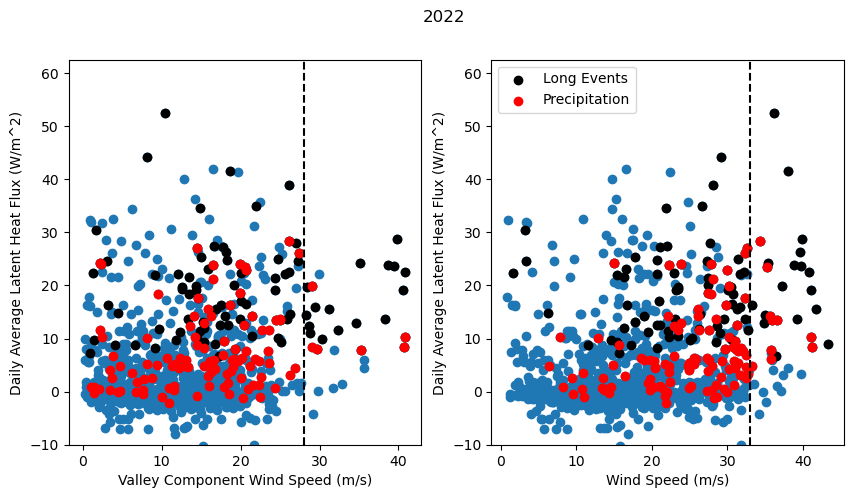

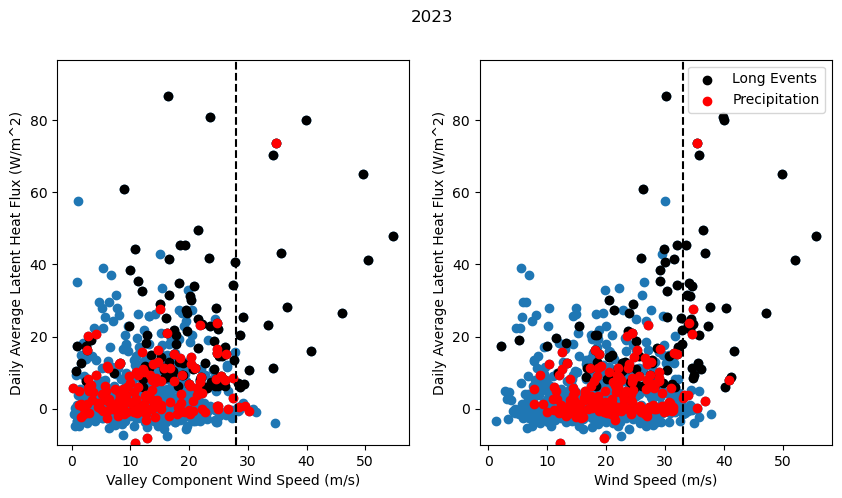

In [15]:
fig = plot_surface_and_reanalysis_vars(latent_heat_flux_2022, w22_precipitation, ds_gt_winter_2022, w22_large_sublimation_spiky_events, w22_large_sublimation_long_events, 'splash_ap', 'valley_component_wind_speed', 'wind_speed')
fig.suptitle('2022')
fig = plot_surface_and_reanalysis_vars(latent_heat_flux_2023, w23_precipitation, ds_gt_winter_2023, w23_large_sublimation_spiky_events, w23_large_sublimation_long_events, 'sos_3m', 'valley_component_wind_speed', 'wind_speed')
fig.suptitle('2023')

Text(0.5, 0.98, '2023')

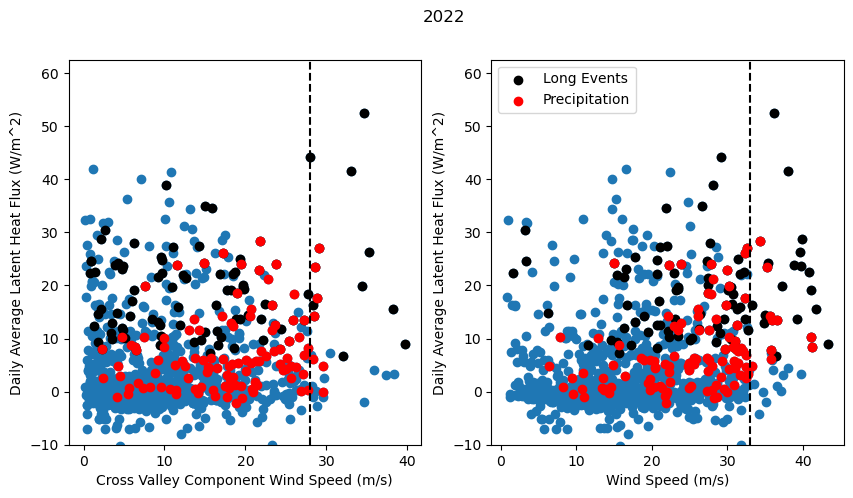

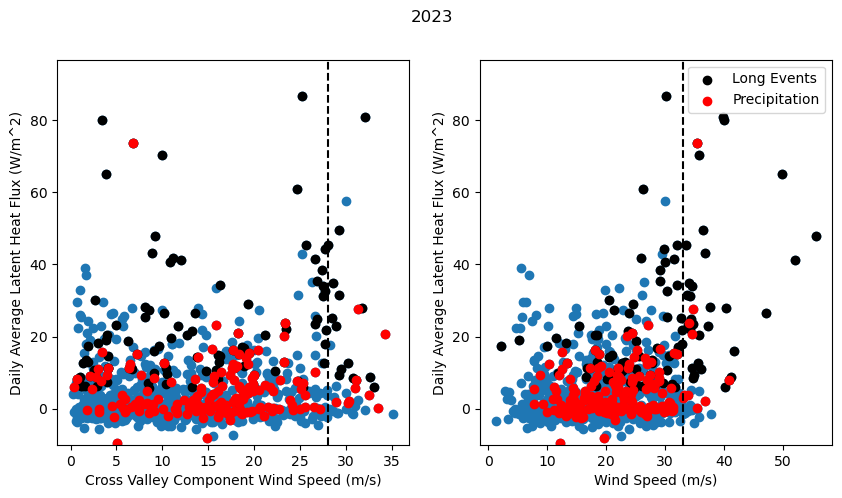

In [16]:
fig = plot_surface_and_reanalysis_vars(latent_heat_flux_2022, w22_precipitation, ds_gt_winter_2022, w22_large_sublimation_spiky_events, w22_large_sublimation_long_events, 'splash_ap', 'cross_valley_component_wind_speed', 'wind_speed')
fig.suptitle('2022')
fig = plot_surface_and_reanalysis_vars(latent_heat_flux_2023, w23_precipitation, ds_gt_winter_2023, w23_large_sublimation_spiky_events, w23_large_sublimation_long_events, 'sos_3m', 'cross_valley_component_wind_speed', 'wind_speed')
fig.suptitle('2023')

# 3. Checking Correlations 

Can do either spearman or pearson

In [17]:
lh_df, ppt_data, era5_ds, short_events, long_events = select_data(latent_heat_flux_2022, w22_precipitation, ds_gt_winter_2022, w22_large_sublimation_spiky_events, w22_large_sublimation_long_events,)

In [18]:
# largest_events = (long_events.groupby('event').mean() > 15)
synoptic_data = era5_ds.to_dataframe()[['q','t','u','v','vo','wind_speed','valley_component_wind_speed','cross_valley_component_wind_speed']].loc[[t[0] for t in long_events.groupby('event').idxmax().values]]
surface_obs = long_events.groupby('event').max().set_index(synoptic_data.index).splash_ap

result = find_best_synoptic_variable(surface_obs, synoptic_data, method='spearman')

print("Best correlated synoptic variable:", result['best_variable'])
print("Correlation coefficient:", result['all_correlations'])

Best correlated synoptic variable: wind_speed
Correlation coefficient: {'q': -0.44545454545454555, 't': -0.09090909090909091, 'u': -0.02727272727272728, 'v': -0.5090909090909091, 'vo': -0.3272727272727273, 'wind_speed': 0.5818181818181819, 'valley_component_wind_speed': 0.4000000000000001, 'cross_valley_component_wind_speed': 0.30000000000000004}


In [19]:
lh_df, ppt_data, era5_ds, short_events, long_events = select_data(latent_heat_flux_2022, w22_precipitation, ds_all_winter_2022, w22_large_sublimation_spiky_events, w22_large_sublimation_long_events,)

In [20]:
# largest_events = (long_events.groupby('event').mean() > 15)
synoptic_data = era5_ds.to_dataframe()[['q','t','u','v','vo','wind_speed','valley_component_wind_speed','cross_valley_component_wind_speed']].loc[[t[0] for t in long_events.groupby('event').idxmax().values]]
surface_obs = long_events.groupby('event').max().set_index(synoptic_data.index).splash_ap

result = find_best_synoptic_variable(surface_obs, synoptic_data, method='spearman')

print("Best correlated synoptic variable:", result['best_variable'])
print("Correlation coefficient:", result['all_correlations'])

Best correlated synoptic variable: v
Correlation coefficient: {'q': -0.4000000000000001, 't': -0.3454545454545455, 'u': -0.16363636363636366, 'v': -0.4272727272727273, 'vo': -0.28181818181818186, 'wind_speed': 0.27272727272727276, 'valley_component_wind_speed': 0.11818181818181818, 'cross_valley_component_wind_speed': 0.14545454545454548}


We averaged the synoptic level (500 mb) data in two differnt ways: the average of a 10x10 ERA5 grid centered over the East River valley and the nearest grid cell over Gothic. We took this data and calculated spearman correlations with the maximum surface latent heat flux observation during long events. 

We found that both the single grid cell and the regional average both correlate well with u-wind and wind-speed. However, large differences are observed for temperature (> for single grid cell), vorticity (> for grid-average)

This likely means that including certain variables may not be super helpful. This is only for the 2023 data.

We get a pretty different story during 2022. For the gridded average, v, q, and t have the largest relationships, with wind speed being much lower. This might be why including these other variables prove to be useful within the model. It seems q, t, u, v, and vo are the most useful. 

## 2022 Data

In [21]:
lh_df, ppt_data, era5_ds, short_events, long_events = select_data(latent_heat_flux_2022, w22_precipitation, ds_gt_winter_2022, w22_large_sublimation_spiky_events, w22_large_sublimation_long_events,)

In [22]:
result = gridsearch_optimal_thresholds(era5_ds, long_events, ppt_data, metric='f1')

print("Best Thresholds:")
print(result['best_thresholds'])

print("\nBest Confusion Matrix:")
print(result['best_confusion_matrix'])

print('2022')
print("\nBest Score (F1-score):", result['best_score'])


Best Thresholds:
{'wind': 0.8, 'specific_humidity': 0.05, 'temperature': 0.9500000000000001}

Best Confusion Matrix:
                 Event  Non-Event
High Wind Speed     63        213
Low Wind Speed     102        866
2022

Best Score (F1-score): 0.2857142857142857


## 2023 Data

In [23]:
lh_df, ppt_data, era5_ds, short_events, long_events = select_data(latent_heat_flux_2023, w23_precipitation, ds_gt_winter_2023, w23_large_sublimation_spiky_events, w23_large_sublimation_long_events,)


In [24]:
result = gridsearch_optimal_thresholds(era5_ds, long_events, ppt_data, metric='f1')

print("Best Thresholds:")
print(result['best_thresholds'])

print("\nBest Confusion Matrix:")
print(result['best_confusion_matrix'])

print("\nBest Score (F1-score):", result['best_score'])


Best Thresholds:
{'wind': 0.9000000000000001, 'specific_humidity': 0.05, 'temperature': 0.9500000000000001}

Best Confusion Matrix:
                 Event  Non-Event
High Wind Speed     49        134
Low Wind Speed     111        857

Best Score (F1-score): 0.28571428571428575


# 4. Merge datasets

In [16]:
# merge the two datasets
if 'splash_ap' in latent_heat_flux_2022.columns:
    latent_heat_flux_2022.rename(columns={'splash_ap': 'sublimation'}, inplace=True)
if 'sos_3m' in latent_heat_flux_2023.columns:
    latent_heat_flux_2023.rename(columns={'sos_3m': 'sublimation'}, inplace=True)
latent_heat_flux = pd.concat([latent_heat_flux_2022, latent_heat_flux_2023], axis=0)

# merge the two datasets
reanalysis_df = xr.merge([ds_all_winter_2022, ds_all_winter_2023]).sel(pressure_level=500)

# calculate vapor pressure deficit
reanalysis_df['vpd'] = calc.saturation_vapor_pressure((reanalysis_df['t'])) - reanalysis_df['q'] * units.units('Pa')

reanalysis_df = reanalysis_df.to_dataframe()[['u','v', 'q','t','vpd','vo','wind_speed','wind_dir','valley_component_wind_speed']]

# add precipitation
precip_df = pd.concat([w22_precipitation, w23_precipitation], axis=0).resample('1H').sum()

# add precipitation to the reanalysis dataframe
reanalysis_df['precipitation'] = precip_df

combined_df = pd.merge(latent_heat_flux, reanalysis_df, left_index=True, right_index=True).resample('3H').mean()

# add event column
combined_df['event'] = 0
combined_df.loc[w22_large_sublimation_long_events.index, 'event'] = 1
# combined_df.loc[w22_large_sublimation_spiky_events.index, 'event'] = 1
combined_df.loc[w23_large_sublimation_long_events.index[:-1], 'event'] = 1
# combined_df.loc[w23_large_sublimation_spiky_events.index, 'event'] = 1

resample = True
if resample:
    # resample the data to 12H
    combined_df_12H = combined_df.resample('12H').agg({'sublimation': 'sum', 
                                                'u': 'mean', 
                                                'v': 'mean', 
                                                't': 'mean',
                                                'vo': 'mean', 
                                                'q' : 'min',
                                                'vpd': 'min',
                                                'wind_speed': 'max', 
                                                'wind_dir': 'mean', 
                                                'precipitation':'sum',
                                                'valley_component_wind_speed': 'mean', 
                                                'event': 'max'})

# reset the index and dropna
combined_df = combined_df.reset_index()

# replace event values equal to 0 with "non-event" and 1 with "event"
combined_df['event'] = combined_df['event'].replace({0: 'non-event', 1: 'event'})

# 5. Percentile rank and cross-correlation figures

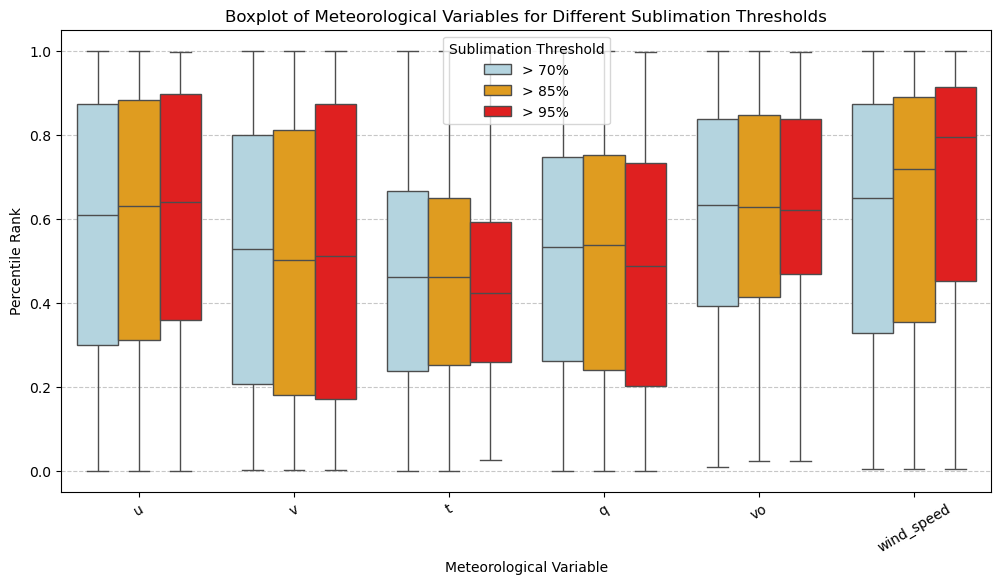

In [17]:
# Calculate percentiles
percentiles = combined_df.rank(method="average", pct=True)[['wind_dir','t', 'q', 'vo', 'wind_speed', 'sublimation', 'u', 'v']]

# Subset for different sublimation thresholds
percentiles_sub_50 = percentiles[percentiles['sublimation'] > 0.75]
percentiles_sub_75 = percentiles[percentiles['sublimation'] > 0.85]
percentiles_sub_95 = percentiles[percentiles['sublimation'] > 0.95]

# Drop 'sublimation' since it's the target variable
variables = ['u','v', 't', 'q', 'vo', 'wind_speed']

# Create a grouped DataFrame for boxplot
melted_50 = percentiles_sub_50[variables].melt(var_name="Variable", value_name="Percentile")
melted_50["Threshold"] = "> 70%"

melted_75 = percentiles_sub_75[variables].melt(var_name="Variable", value_name="Percentile")
melted_75["Threshold"] = "> 85%"

melted_95 = percentiles_sub_95[variables].melt(var_name="Variable", value_name="Percentile")
melted_95["Threshold"] = "> 95%"

# Combine into a single dataframe
plot_data = pd.concat([melted_50, melted_75, melted_95])

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x="Variable", y="Percentile", hue="Threshold", data=plot_data, palette=["lightblue", "orange", "red"])

# Customization
plt.title("Boxplot of Meteorological Variables for Different Sublimation Thresholds")
plt.xlabel("Meteorological Variable")
plt.ylabel("Percentile Rank")
plt.legend(title="Sublimation Threshold", loc='upper center')
plt.xticks(rotation=30)  # Rotate x labels for better readability

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


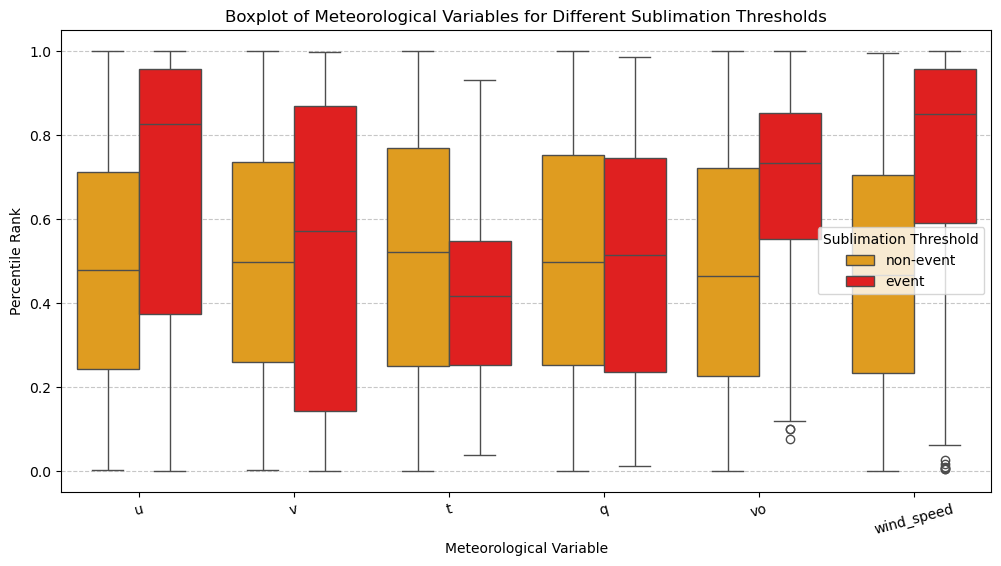

In [18]:
# Calculate percentiles
percentiles = combined_df.rank(method="average", pct=True)[['u', 'v','t', 'q', 'vo', 'wind_speed', 'sublimation']]

# Subset for different sublimation thresholds
percentiles_event = percentiles[combined_df['event']=='event']
percentiles_non_event = percentiles[combined_df['event']=='non-event']

# Drop 'sublimation' since it's the target variable
variables = ['u','v','t', 'q', 'vo', 'wind_speed']

# Create a grouped DataFrame for boxplot
melted_non_event = percentiles_non_event[variables].melt(var_name="Variable", value_name="Percentile")
melted_non_event["Threshold"] = "non-event"

melted_event = percentiles_event[variables].melt(var_name="Variable", value_name="Percentile")
melted_event["Threshold"] = "event"

# Combine into a single dataframe
plot_data = pd.concat([melted_non_event, melted_event]).reset_index(drop=True)

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x="Variable", y="Percentile", hue="Threshold", data=plot_data, palette=["orange", "red"])

# Customization
plt.title("Boxplot of Meteorological Variables for Different Sublimation Thresholds")
plt.xlabel("Meteorological Variable")
plt.ylabel("Percentile Rank")
plt.legend(title="Sublimation Threshold")
plt.xticks(rotation=15)  # Rotate x labels for better readability

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


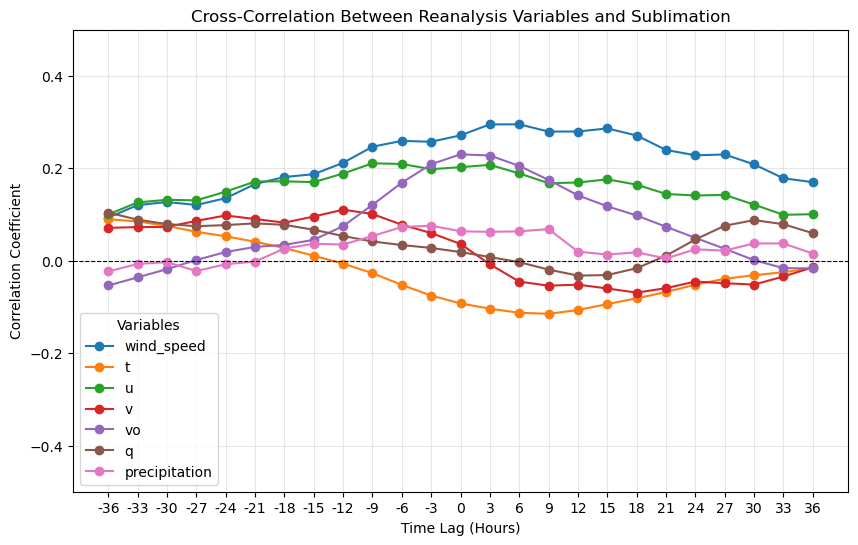

In [19]:
# Example usage
cross_corrs = compute_cross_correlation(combined_df[['wind_speed', 't', 'u', 'v', 'vo', 'sublimation', 'q', 'precipitation']], target_var='sublimation', lag_range=(-12, 12))

# Plot correlation results
plt.figure(figsize=(10, 6))
for var in cross_corrs.columns:
    plt.plot(cross_corrs.index, cross_corrs[var], label=var, marker='o', linestyle='-')

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Reference line at 0
# change out the x-axis for hours by multiplying by 3
plt.xticks(np.arange(-12, 13, 1), labels=np.arange(-12, 13, 1)*3)
plt.xlabel("Time Lag (Hours)")
plt.ylabel("Correlation Coefficient")
plt.title("Cross-Correlation Between Reanalysis Variables and Sublimation")
plt.legend(title="Variables")
plt.grid(alpha=0.3)
plt.ylim(-0.5,0.5)
plt.show()


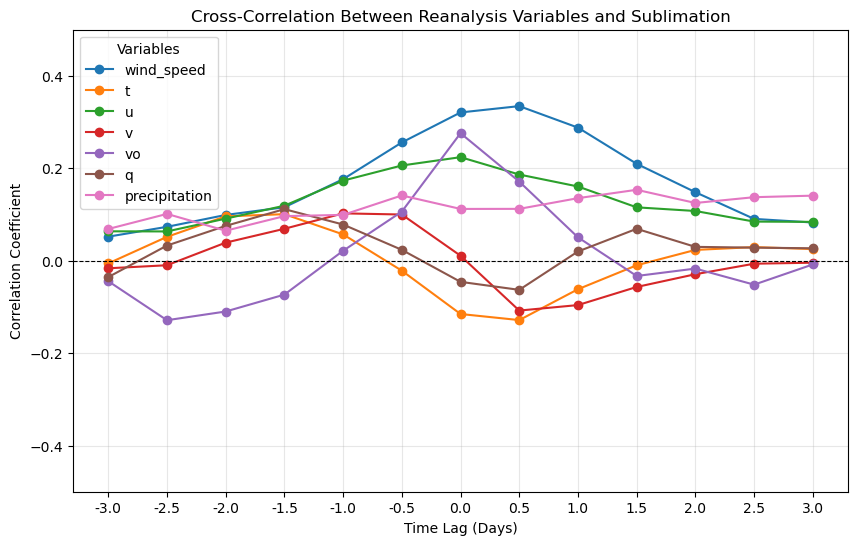

In [20]:
# Example usage
cross_corrs = compute_cross_correlation(combined_df_12H[['wind_speed', 't', 'u', 'v', 'vo', 'sublimation', 'q', 'precipitation']], 
                                        target_var='sublimation', 
                                        lag_range=(-6, 6))

# Plot correlation results
plt.figure(figsize=(10, 6))
for var in cross_corrs.columns:
    plt.plot(cross_corrs.index, cross_corrs[var], label=var, marker='o', linestyle='-')

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)  # Reference line at 0
# change out the x-axis for hours by multiplying by 3
plt.xticks(np.arange(-6, 7, 1), labels=np.arange(-6, 7, 1)/2)
plt.xlabel("Time Lag (Days)")
plt.ylabel("Correlation Coefficient")
plt.title("Cross-Correlation Between Reanalysis Variables and Sublimation")
plt.legend(title="Variables")
plt.grid(alpha=0.3)
plt.ylim(-0.5,0.5)
plt.show()


# 6. Figures to support model decisions.

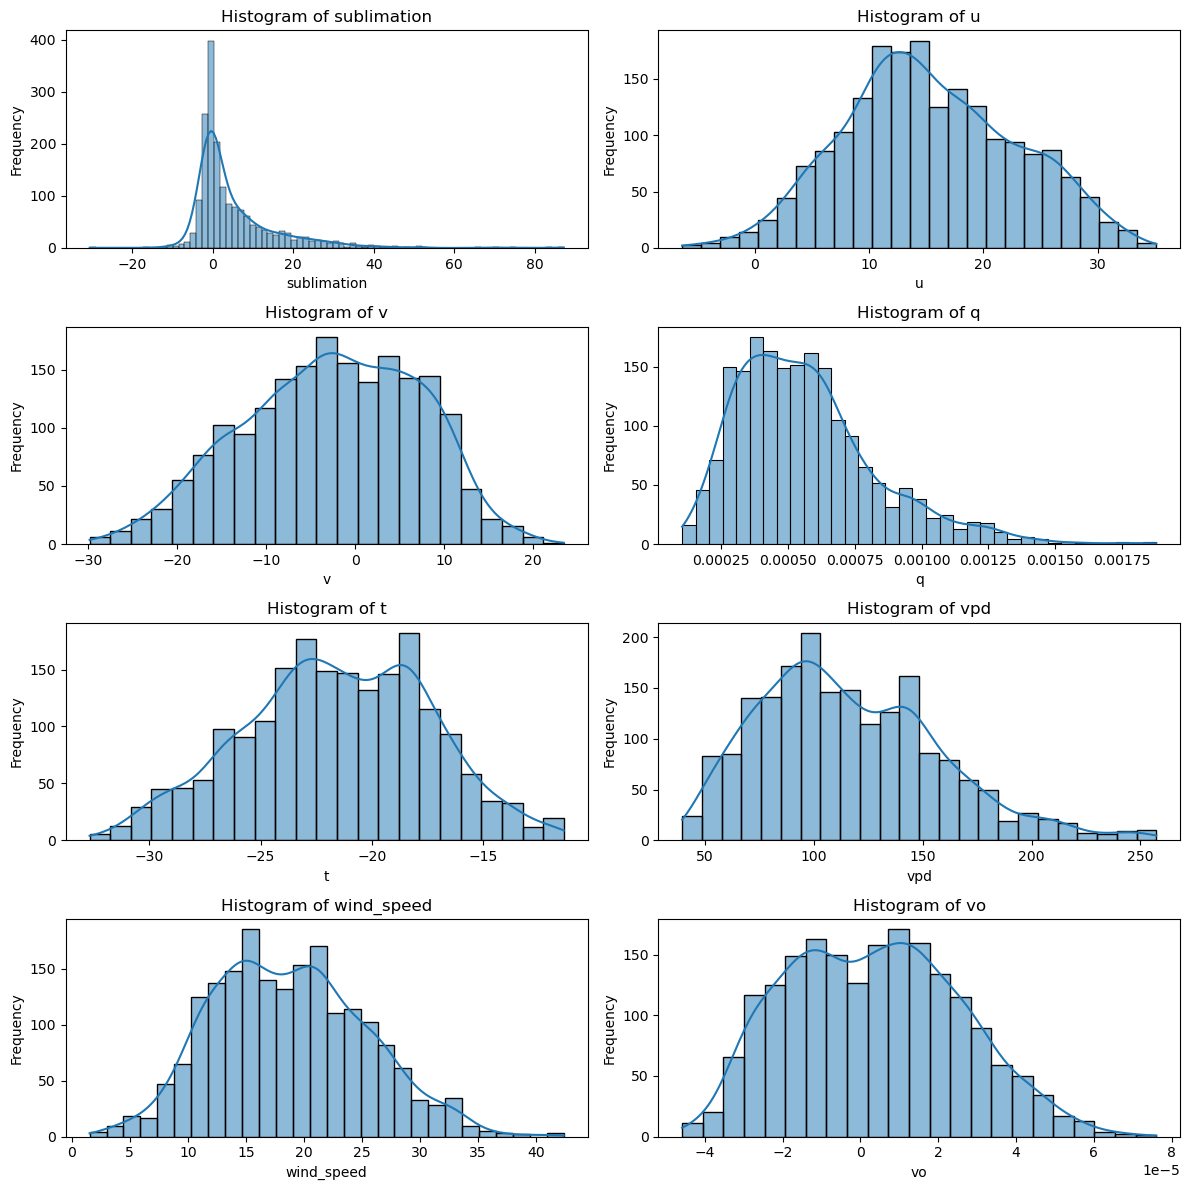

In [21]:
vars_to_plot = ['sublimation', 'u', 'v', 'q', 't', 'vpd', 'wind_speed', 'vo']

# plot histograms of each variable in vars_to_plot
fig, axs = plt.subplots(4, 2, figsize=(12, 12))
for ax, var in zip(axs.flat, vars_to_plot):
    sns.histplot(combined_df[var], ax=ax, kde=True)
    ax.set_title(f"Histogram of {var}")
    ax.set_xlabel(var)
    ax.set_ylabel("Frequency")
plt.tight_layout()

/tmp/ipykernel_26738/2190474484.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



[Text(0, 0, 'Non-Event'), Text(1, 0, 'Event')]

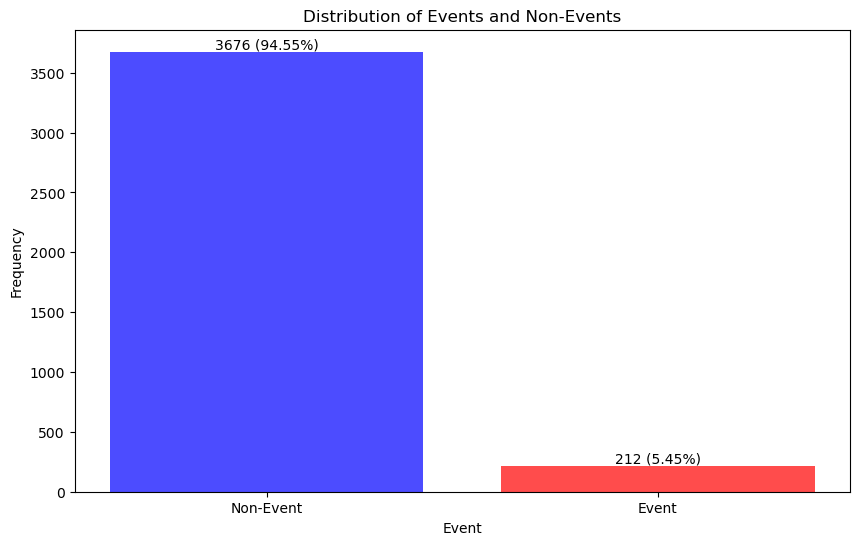

In [22]:
# create distribution of events and non-events
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(combined_df['event'].value_counts().index, combined_df['event'].value_counts().values, color=['blue', 'red'], alpha=0.7)
# add percentage of events and non-events
for i, count in enumerate(combined_df['event'].value_counts().values):
    ax.text(i, count, f"{count} ({count/combined_df.shape[0]*100:.2f}%)", ha='center', va='bottom')
ax.set_title("Distribution of Events and Non-Events")
ax.set_xlabel("Event")
ax.set_ylabel("Frequency")
ax.set_xticklabels(["Non-Event", "Event"])

This plot shows that:
- our target is imbalanced
- we can expect a high bias for non-events
- class weights must be balanced on training data

# 7. Step-wise logistic regression classifier

In [23]:
def stepwise_logistic_regression(df, target, feature_list, max_steps=None):
    """
    Perform stepwise logistic regression by iteratively adding features and evaluating performance.

    Parameters:
    - df: pandas DataFrame with features + target.
    - target: Name of the target column.
    - feature_list: List of features to consider for stepwise addition.
    - max_steps: Maximum number of features to add (default is all).

    Returns:
    - DataFrame with stepwise performance results.
    """
    # Step 1: Define Features (X) and Target (y)
    X = df[feature_list]
    y = df[target]

    # Step 2: Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)  # Apply standardization

    # Step 3: Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Step 4: Convert to DataFrame for easier handling
    X_train = pd.DataFrame(X_train, columns=feature_list)
    X_test = pd.DataFrame(X_test, columns=feature_list)

    selected_features = []
    step_results = []

    for i, feature in enumerate(feature_list):
        selected_features.append(feature)
        X_train_subset = X_train[selected_features].values  # Add intercept
        X_test_subset = X_test[selected_features].values

        # Fit Logistic Regression Model
        # model = sm.Logit(y_train.values, X_train_subset).fit(disp=0)
        model = LogisticRegression(solver='liblinear', random_state=42, penalty='l2').fit(X_train_subset, y_train.values)

        # Predict Probabilities & Convert to Binary Labels
        y_pred_prob = model.predict(X_test_subset)
        y_pred = (y_pred_prob > 0.5).astype(int)

        # Evaluate performance
        accuracy = accuracy_score(y_test.values, y_pred)
        f1 = f1_score(y_test.values, y_pred)
        recall = recall_score(y_test.values, y_pred)
        precision = precision_score(y_test.values, y_pred)
        average_precision = average_precision_score(y_test.values, y_pred)
        

        step_results.append({
            "Step": i+1,
            "Features": list(selected_features),
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Recall": recall,
            "Precision": precision,
            "Average Precision": average_precision
        })
        # Stop if max steps reached
        if max_steps and i+1 >= max_steps:
            break

    return pd.DataFrame(step_results)

# Example usage
features = ['wind_speed', 'vo', 't', 'q', 'u', 'v', 'precipitation']

input_df = combined_df.dropna(how='any').replace({'event': {'non-event': 0, 'event': 1}}).reset_index(drop=True)
# Perform stepwise logistic regression on the combined DataFrame
logreg_stepwise_results = stepwise_logistic_regression(input_df, target='event', feature_list=features)

print(logreg_stepwise_results)


   Step                                     Features  Accuracy  F1 Score  \
0     1                                 [wind_speed]  0.891107  0.062500   
1     2                             [wind_speed, vo]  0.900181  0.352941   
2     3                          [wind_speed, vo, t]  0.905626  0.350000   
3     4                       [wind_speed, vo, t, q]  0.905626  0.350000   
4     5                    [wind_speed, vo, t, q, u]  0.909256  0.358974   
5     6                 [wind_speed, vo, t, q, u, v]  0.909256  0.375000   
6     7  [wind_speed, vo, t, q, u, v, precipitation]  0.914701  0.405063   

     Recall  Precision  Average Precision  
0  0.033333   0.500000           0.121930  
1  0.250000   0.600000           0.231670  
2  0.233333   0.700000           0.246818  
3  0.233333   0.700000           0.246818  
4  0.233333   0.777778           0.264966  
5  0.250000   0.750000           0.269170  
6  0.266667   0.842105           0.304416  


# 8. Synthetic Minority Oversampling Technique 

In [24]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

In [25]:
features = ['wind_speed', 'vo', 't', 'q', 'u', 'v', 'precipitation']
# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_df[features], combined_df['event'], test_size=0.25, random_state=42)
X, y = combined_df[features], combined_df['event']

# for y, replace non-event with 0 and event with 1

In [26]:
def stepwise_SMOTE_decision_tree(df, target, feature_list, max_steps=None):
    """
    Perform stepwise SMOTE decision tree and evaluate performatnce

    Parameters:
    - df: pandas DataFrame with features + target.
    - target: Name of the target column.
    - feature_list: List of features to consider for stepwise addition.
    - max_steps: Maximum number of features to add (default is all).

    Returns:
    - DataFrame with stepwise performance results.
    """
    # Step 1: Define Features (X) and Target (y)
    X = df[feature_list]
    y = df[target]

    selected_features = []
    step_results = []

    for i,feature in enumerate(feature_list):
        selected_features.append(feature)
        X_subset = X[selected_features] 
        model = DecisionTreeClassifier()

        # define pipeline
        over = SMOTE(sampling_strategy=0.5, k_neighbors=5, random_state=42)  # Adjust k_neighbors to the current value of k
        under = RandomUnderSampler(sampling_strategy=0.5)
        steps = [('o', over), ('under', under), ('model', model)]
        pipeline = Pipeline(steps=steps)
    
        # evalevaluate pipeline, cross-validation
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
        f1 = cross_val_score(pipeline, X=X_subset, y=y, scoring='f1', cv=cv, n_jobs=-1)
        precision = cross_val_score(pipeline, X=X_subset, y=y, scoring='precision', cv=cv, n_jobs=-1)
        recall = cross_val_score(pipeline, X=X_subset, y=y, scoring='recall', cv=cv, n_jobs=-1)
        accuracy = cross_val_score(pipeline, X=X_subset, y=y, scoring='accuracy', cv=cv, n_jobs=-1)
        average_precision = cross_val_score(pipeline, X=X_subset, y=y, scoring='average_precision', cv=cv, n_jobs=-1)
        
        # Store results
        step_results.append({
            "Step": i+1,
            "Features": list(selected_features),
            "Accuracy": accuracy.mean(),
            "F1 Score": f1.mean(),
            "Recall": recall.mean(),
            "Precision": precision.mean(),
            "Average Precision": average_precision.mean()
        })
        # Stop if max steps reached
        if max_steps and i+1 >= max_steps:
            break

    return pd.DataFrame(step_results)

# Example usage
features = ['wind_speed', 'vo', 't', 'q', 'u', 'v', 'precipitation']

input_df = combined_df.dropna(how='any').replace({'event': {'non-event': 0, 'event': 1}}).reset_index(drop=True)
# Perform stepwise logistic regression on the combined DataFrame
smote_stepwise_results = stepwise_SMOTE_decision_tree(input_df, target='event', feature_list=features)

print(smote_stepwise_results)


   Step                                     Features  Accuracy  F1 Score  \
0     1                                 [wind_speed]  0.743633  0.246527   
1     2                             [wind_speed, vo]  0.808461  0.329776   
2     3                          [wind_speed, vo, t]  0.867829  0.469188   
3     4                       [wind_speed, vo, t, q]  0.873822  0.504211   
4     5                    [wind_speed, vo, t, q, u]  0.881626  0.542290   
5     6                 [wind_speed, vo, t, q, u, v]  0.899047  0.588913   
6     7  [wind_speed, vo, t, q, u, v, precipitation]  0.900320  0.580134   

     Recall  Precision  Average Precision  
0  0.386538   0.181368           0.139945  
1  0.438675   0.272065           0.186071  
2  0.567650   0.424955           0.296352  
3  0.591111   0.433741           0.290947  
4  0.621624   0.473678           0.337467  
5  0.665171   0.528831           0.389601  
6  0.648504   0.539412           0.381735  


# 9. Random Forest Regressor and Classifier

### Random Forest Regression

In [27]:
combined_df = combined_df.dropna()
# Step 2: Load your dataframe (replace 'df' with your actual dataframe)
# Example assuming 'df' is your dataframe containing predictors (X) and target (y)
X = combined_df[['wind_speed','q','t','vo','v','u', 'precipitation']]
y = combined_df['sublimation']

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Create a random forest regressor model
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)

# Step 5: Train the model on the training data
rf_model.fit(X_train, y_train)

# Step 6: Evaluate the model
# Assess performance on the test set (you can use different metrics depending on your problem)
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)
print(f"Training R^2 score: {train_score:.2f}")
print(f"Testing R^2 score: {test_score:.2f}")
# evaluate with mean squared error
from sklearn.metrics import mean_squared_error
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")


# Step 7: Assess feature importances
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
sorted_importances = feature_importances.sort_values('importance', ascending=False)
print(sorted_importances)

Training R^2 score: 0.90
Testing R^2 score: 0.25
Mean Squared Error: 83.98
         feature  importance
0     wind_speed    0.223945
3             vo    0.214596
2              t    0.147367
5              u    0.138675
4              v    0.133066
1              q    0.122918
6  precipitation    0.019434


### Random Forest Classifier

No cross validation

In [28]:
# Step 1: Load your dataframe
# Assuming 'combined_df' is your dataframe
X = combined_df[['wind_speed', 'u','v', 'q', 't','vo']]
y = combined_df['event'].replace({'event':1, 'non-event':0}) # Convert to binary classification (Event = 1, Non-Event = 0)

# Step 2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Create a Random Forest Classifier model
rf_model = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight="balanced")

# Step 4: Train the model on the training data
rf_model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = rf_model.predict(X_test)

# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Step 6: Assess feature importances
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
sorted_importances = feature_importances.sort_values('importance', ascending=False)
print("\nFeature Importances:")
print(sorted_importances)

Accuracy: 0.92

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       491
           1       0.77      0.33      0.47        60

    accuracy                           0.92       551
   macro avg       0.85      0.66      0.71       551
weighted avg       0.91      0.92      0.90       551


Confusion Matrix:
[[485   6]
 [ 40  20]]

Feature Importances:
      feature  importance
5          vo    0.207944
4           t    0.205286
0  wind_speed    0.204066
1           u    0.165621
2           v    0.124093
3           q    0.092990


In [29]:
def stepwise_random_forest(df, target, feature_list, max_steps=None):
    """
    Perform stepwise SMOTE decision tree and evaluate performatnce

    Parameters:
    - df: pandas DataFrame with features + target.
    - target: Name of the target column.
    - feature_list: List of features to consider for stepwise addition.
    - max_steps: Maximum number of features to add (default is all).

    Returns:
    - DataFrame with stepwise performance results.
    """
    # Step 1: Define Features (X) and Target (y)
    X = df[feature_list]
    y = df[target]

    selected_features = []
    step_results = []

    for i,feature in enumerate(feature_list):
        selected_features.append(feature)
        X = df[selected_features]
        
        # Step 2: Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Step 3: Create and train Random Forest model
        rf_model = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight="balanced")
        rf_model.fit(X_train, y_train)
        
        # Step 4: Evaluate model
        y_pred = rf_model.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        ap = average_precision_score(y_test, y_pred)  # Optional: Average precision score for additional evaluation
        
        
        # Store results
        step_results.append({
            "Step": i+1,
            "Features": list(selected_features),
            "Accuracy": accuracy.mean(),
            "F1 Score": f1.mean(),
            "Recall": recall.mean(),
            "Precision": precision.mean(),
            "Average Precision": ap.mean()
        })
        # Stop if max steps reached
        if max_steps and i+1 >= max_steps:
            break

    return pd.DataFrame(step_results)

# Example usage
features = ['wind_speed', 'vo', 't', 'q', 'u', 'v', 'precipitation']

input_df = combined_df.dropna(how='any').replace({'event': {'non-event': 0, 'event': 1}}).reset_index(drop=True)
# Perform stepwise logistic regression on the combined DataFrame
rf_stepwise_results = stepwise_random_forest(input_df, target='event', feature_list=features)

print(rf_stepwise_results)


   Step                                     Features  Accuracy  F1 Score  \
0     1                                 [wind_speed]  0.825771  0.200000   
1     2                             [wind_speed, vo]  0.894737  0.369565   
2     3                          [wind_speed, vo, t]  0.903811  0.390805   
3     4                       [wind_speed, vo, t, q]  0.905626  0.446809   
4     5                    [wind_speed, vo, t, q, u]  0.914701  0.471910   
5     6                 [wind_speed, vo, t, q, u, v]  0.920145  0.488372   
6     7  [wind_speed, vo, t, q, u, v, precipitation]  0.914701  0.447059   

     Recall  Precision  Average Precision  
0  0.200000   0.200000           0.127114  
1  0.283333   0.531250           0.228561  
2  0.283333   0.629630           0.256435  
3  0.350000   0.617647           0.286957  
4  0.350000   0.724138           0.324229  
5  0.350000   0.807692           0.353473  
6  0.316667   0.760000           0.315077  


# 10. XGBoost Decision Tree

A Stratified Shuffle Split is a data-splitting method that ensures each split maintains the same class distribution as the original dataset while randomly shuffling the data. It’s particularly useful for imbalanced classification problems, where certain classes might be underrepresented.

🔹 How It Works:
Stratification: The dataset is split so that each class maintains its proportion in both training and test sets.
Shuffling: The data is shuffled before splitting, ensuring randomness across multiple splits.
Multiple Splits: It allows you to generate multiple train-test splits, which helps in robust model evaluation by reducing variance.

🔹 Why Use It?

✅ Prevents bias from imbalanced data by keeping class proportions consistent.

✅ Improves model evaluation by reducing variability across different train-test splits.

✅ Useful for rare event classification (e.g., fraud detection, medical diagnosis).

In [30]:
def train_xgb_model(df, feature_list, target, test_size=0.25, max_features=None, standardize=False, stratified=False):
    X = df[feature_list].values
    y = df[target]

    # Step 1: Standardize features
    if standardize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    
    # Step 2: Train/Test split using StratifiedShuffleSplit
    if stratified:
        ss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
        for train_index, test_index in ss.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
    else:
        # Step 2: Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    # Convert to DataFrame for easier handling
    selected_features = feature_list[:max_features] if max_features else feature_list
    X_train = pd.DataFrame(X_train, columns=feature_list)
    X_test = pd.DataFrame(X_test, columns=feature_list)
    y_train = pd.Series(y_train, name=target).replace({'non-event':0, 'event':1})
    y_test = pd.Series(y_test, name=target).replace({'non-event':0, 'event':1})
    return X_train, X_test, y_train, y_test, selected_features

# Example usage
X_train, X_test, y_train, y_test, selected_features = train_xgb_model(
    combined_df,
    feature_list=['wind_speed', 't', 'q', 'u', 'v', 'vo'],
    target='event',
    test_size=0.3,
    max_features=None,
    standardize=False,
    stratified=False
)

Baseline model

In [31]:
baseline_xgb_model = XGBClassifier(random_state=42, 
                                   learning_rate= 0.01, 
                                   max_depth=3, 
                                   n_estimators= 500, 
                                   scale_pos_weight= 5, 
                                   subsample= 0.3,
                                   objective="binary:logistic")

In [32]:
model = baseline_xgb_model.fit(X_train, y_train)
# Evaluate model
y_pred = model.predict(X_test[selected_features])
y_pred_probs = model.predict_proba(X_test[selected_features])[:, 1]  # Get probabilities for AP score

f1 = f1_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred_probs)  # Compute AP score
# compute recall score
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)
# Print final results
print(f"\nMean F1 Score: {f1:.4f}")
print(f"Mean Recall Score: {recall:.4f}")
print(f"Mean Average Precision Score (PR AUC): {ap}")
print("\nBest Classification Report:\n", classification_report_str)
print("\nBest Confusion Matrix:\n", cm)


Mean F1 Score: 0.5106
Mean Recall Score: 0.6000
Mean Average Precision Score (PR AUC): 0.5784788929341003

Best Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       491
           1       0.44      0.60      0.51        60

    accuracy                           0.87       551
   macro avg       0.70      0.75      0.72       551
weighted avg       0.89      0.87      0.88       551


Best Confusion Matrix:
 [[446  45]
 [ 24  36]]


### Hyper-parameter Tuning

In [33]:
# # Randomized Search for Hyperparameter Tuning
# param_grid = {
#     'max_depth': [2, 4, 6, 8],
#     'learning_rate': [0.001, 0.01, 0.1, 0.2],
#     'n_estimators': [100, 300, 500, 1000],
#     'subsample': [0.3, 0.5, 0.8, 1.0],
#     'colsample_bytree': [0.3, 0.5, 0.8, 1.0],
#     'scale_pos_weight': [1, 5, 10, 20]
# }
# xgb = XGBClassifier(objective="binary:logistic", random_state=42)
# random_search = RandomizedSearchCV(xgb, param_grid, n_iter=20, scoring="f1", cv=5, random_state=42,verbose=2, n_jobs=4)
# random_search.fit(X_train, y_train)

# print(random_search.best_params_)

In [34]:
improved_xgb_model = XGBClassifier(
    objective="binary:logistic",
    **{'subsample': 0.3, 'scale_pos_weight': 20, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
)

In [35]:
model = improved_xgb_model.fit(X_train, y_train)
# Evaluate model
y_pred = model.predict(X_test[selected_features])
y_pred_probs = model.predict_proba(X_test[selected_features])[:, 1]  # Get probabilities for AP score

f1 = f1_score(y_test, y_pred)
ap = average_precision_score(y_test, y_pred_probs)  # Compute AP score
# compute recall score
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)
# Print final results
print(f"\nMean F1 Score: {f1:.4f}")
print(f"Mean Recall Score: {recall:.4f}")
print(f"Mean Average Precision Score (PR AUC): {ap}")
print("\nBest Classification Report:\n", classification_report_str)
print("\nBest Confusion Matrix:\n", cm)


Mean F1 Score: 0.5913
Mean Recall Score: 0.5667
Mean Average Precision Score (PR AUC): 0.6773119923560185

Best Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       491
           1       0.62      0.57      0.59        60

    accuracy                           0.91       551
   macro avg       0.78      0.76      0.77       551
weighted avg       0.91      0.91      0.91       551


Best Confusion Matrix:
 [[470  21]
 [ 26  34]]


GridSearch

In [51]:
def stepwise_xgb_classification(df, target, feature_list, max_steps=None, n_splits=5):
    """
    Perform stepwise classification using XGBoost and evaluate performance.

    Parameters:
    - df: pandas DataFrame containing features and target.
    - target: Name of the target column.
    - feature_list: List of features to use.
    - max_steps: Maximum number of features to include (default is all).
    - n_splits: Number of train-test splits for robust evaluation (default is 5).

    Returns:
    - DataFrame summarizing mean & std of F1 scores and AP scores across splits.
    - Confusion matrix of the best-performing model.
    """
    X = df[feature_list].values
    y = df[target]

    # Step 1: Standardize features
    # scaler = MinMaxScaler()
    # X_scaled = scaler.fit_transform(X)

    # Step 2: Train/Test split using StratifiedShuffleSplit
    ss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.3, random_state=42)
    
    selected_features = []  # Track selected features for each step
    step_results = []
    f1_scores = []
    precision_scores = []  # Store average precision scores
    recall_scores = []  # Store recall scores
    accuracy_scores = []  # Store accuracy scores
    ap_scores = []  # Store average precision scores
    best_f1 = 0
    best_conf_matrix = None
    best_classification_report = None

   
    for i,feature in enumerate(feature_list):
        # Select features up to the current step
        selected_features.append(feature)
        f1_scores = []
        precision_scores = []  # Store average precision scores
        recall_scores = []  # Store recall scores
        accuracy_scores = []  # Store accuracy scores
        ap_scores = []  # Store average precision scores
        for train_index, test_index in ss.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Convert to DataFrame for easier handling
            X_train = pd.DataFrame(X_train, columns=feature_list)
            X_test = pd.DataFrame(X_test, columns=feature_list)

            # Train an XGBoost model
            if i == 0:
                model = improved_xgb_model #XGBClassifier(random_state=42, learning_rate= 0.01, max_depth=3, n_estimators= 500, scale_pos_weight= 5, subsample= 0.8)
            else:
                model=model # Use the previously trained model for subsequent steps
            # Fit the model on the selected features
            model.fit(X_train[selected_features], y_train)

            # Evaluate model
            y_pred = model.predict(X_test[selected_features])
            y_pred_probs = model.predict_proba(X_test[selected_features])[:, 1]  # Get probabilities for AP score

            f1 = f1_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)  # Compute precision score
            recall = recall_score(y_test, y_pred)
            accuracy = accuracy_score(y_test, y_pred)
            ap = average_precision_score(y_test, y_pred_probs)

            # Store F1 and AP scores
            f1_scores.append(f1)
            precision_scores.append(precision)
            recall_scores.append(recall)  # Store recall scores
            accuracy_scores.append(accuracy)
            ap_scores.append(ap)  # Store average precision scores

            # Track best model based on F1 score
            if f1 > best_f1:
                best_f1 = f1
                best_conf_matrix = confusion_matrix(y_test, y_pred)
                best_classification_report = classification_report(y_test, y_pred)

        # Compute mean and standard deviation of F1 and AP scores
        step_results.append({
            "Step": i+1,
            "Features": list(selected_features),
            "Accuracy": np.mean(accuracy_scores),
            "F1 Score": np.mean(f1_scores),
            "Recall": np.mean(recall_scores),
            "Precision": np.mean(precision_scores),
            "Average Precision": np.mean(ap_scores)  # Store mean AP score
        })

    return pd.DataFrame(
        step_results
    ), best_conf_matrix, model

# Example usage
features = ['wind_speed', 't', 'q', 'u','v','vo']
input_df = combined_df.dropna(how='any').replace({'event': {'non-event': 0, 'event': 1}}).reset_index(drop=True)
# Perform stepwise XGBoost classification on the combined DataFrame
xgb_stepwise_results, best_conf_matrix, xgb_model = stepwise_xgb_classification(input_df, target='event', feature_list=features, max_steps=len(features))
print("\nBest Confusion Matrix:")
print(best_conf_matrix)



Best Confusion Matrix:
[[477  14]
 [ 18  42]]


### Balanced Random Forest Classifier

In [46]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import average_precision_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

def stepwise_balanced_rf_classification(df, target, feature_list, max_steps=None, n_splits=10):
    """
    Perform stepwise classification using Balanced Random Forest and evaluate performance.

    Parameters:
    - df: pandas DataFrame containing features and target.
    - target: Name of the target column.
    - feature_list: List of features to use.
    - max_steps: Maximum number of features to include (default is all).
    - n_splits: Number of train-test splits for robust evaluation (default is 10).

    Returns:
    - DataFrame summarizing mean & std of F1 scores and AP scores across splits.
    - Confusion matrix of the best-performing model.
    """
    X = df[feature_list].values
    y = df[target]

    # Step 1: Standardize features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Step 2: Train/Test split using StratifiedShuffleSplit
    ss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.3, random_state=42)

    f1_scores = []
    ap_scores = []  # Store average precision scores
    best_f1 = 0
    best_conf_matrix = None
    best_classification_report = None

    for train_index, test_index in ss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Convert to DataFrame for easier handling
        X_train = pd.DataFrame(X_train, columns=feature_list)
        X_test = pd.DataFrame(X_test, columns=feature_list)

        selected_features = feature_list[:max_steps] if max_steps else feature_list

        # Train a Balanced Random Forest model
        model = BalancedRandomForestClassifier(n_estimators=500, random_state=42)
        model.fit(X_train[selected_features], y_train)

        # Evaluate model
        y_pred = model.predict(X_test[selected_features])
        y_pred_probs = model.predict_proba(X_test[selected_features])[:, 1]  # Get probabilities for AP score

        f1 = f1_score(y_test, y_pred)
        ap = average_precision_score(y_test, y_pred_probs)  # Compute AP score

        # Store F1 and AP scores
        f1_scores.append(f1)
        ap_scores.append(ap)

        # Track best model based on F1 score
        if f1 > best_f1:
            best_f1 = f1
            best_conf_matrix = confusion_matrix(y_test, y_pred)
            best_classification_report = classification_report(y_test, y_pred)

    # Compute mean and standard deviation of F1 and AP scores
    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    mean_ap = np.mean(ap_scores)
    std_ap = np.std(ap_scores)

    # Print final results
    print(f"\nMean F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")
    print(f"Mean Average Precision Score (PR AUC): {mean_ap:.4f} ± {std_ap:.4f}")
    print("\nBest Classification Report:\n", best_classification_report)
    print("\nBest Confusion Matrix:\n", best_conf_matrix)

    return pd.DataFrame({
        "Mean F1 Score": [mean_f1], "F1 Std Dev": [std_f1],
        "Mean AP Score": [mean_ap], "AP Std Dev": [std_ap]
    }), best_conf_matrix
# Example usage
features = ['wind_speed', 't', 'q',]
input_df = combined_df.dropna(how='any').replace({'event': {'non-event': 0, 'event': 1}}).reset_index(drop=True)
# Perform stepwise Balanced Random Forest classification on the combined DataFrame
stepwise_results, best_conf_matrix = stepwise_balanced_rf_classification(input_df, target='event', feature_list=features, max_steps=len(features))
print("\nBest Confusion Matrix:")
print(best_conf_matrix)



Mean F1 Score: 0.4574 ± 0.0339
Mean Average Precision Score (PR AUC): 0.5066 ± 0.0402

Best Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.84      0.90       491
           1       0.37      0.78      0.50        60

    accuracy                           0.83       551
   macro avg       0.67      0.81      0.70       551
weighted avg       0.90      0.83      0.85       551


Best Confusion Matrix:
 [[410  81]
 [ 13  47]]

Best Confusion Matrix:
[[410  81]
 [ 13  47]]


# 11. Compare Model Performance

<Axes: xlabel='Model', ylabel='value'>

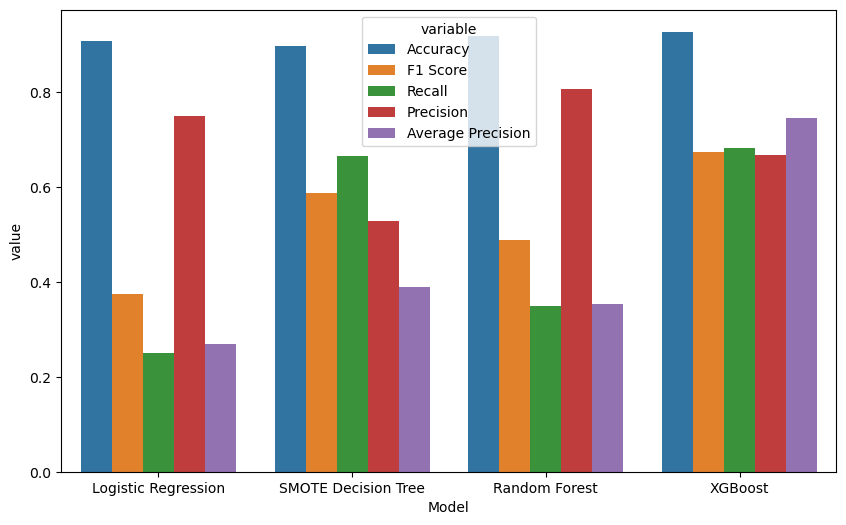

In [52]:
fig, ax = plt.subplots(figsize=(10, 6))

result = [logreg_stepwise_results, smote_stepwise_results, rf_stepwise_results, xgb_stepwise_results]
models = ['Logistic Regression', 'SMOTE Decision Tree', 'Random Forest', 'XGBoost']
dfs = []
for i, r_df in enumerate(result):
    df = r_df.melt(id_vars=['Features'], value_vars=['Accuracy', 'F1 Score', 'Recall', 'Precision', 'Average Precision'])
    df['Model'] = models[i]
    dfs.append(df)

features = list(['wind_speed', 't', 'q', 'u', 'v', 'vo'])
df = pd.concat(dfs)
# Filter for the selected features
metric_df = df[df['Features'].apply(lambda x: all(f in x for f in features) and (len(x) == len(features)))]

# converty features to string
metric_df['Features'] = metric_df['Features'].apply(lambda x: ', '.join(x))

# plot the as a bar plot
sns.barplot(data=metric_df, x='Model', y='value', hue='variable', ax=ax)

# 12. Apply to remaining years

In [77]:
water_years = np.arange(1980,2025)
result_df = pd.DataFrame(index=water_years, columns=['no_of_events', 'length_of_winter', 'percentage_of_events', 'discrete_events'])
monthly_results = pd.DataFrame(index=water_years, columns=['December', 'January', 'February', 'March'])
for water_year in water_years:
    print(f"Opening {water_year} data...")
    winter_slice = slice(f'{water_year-1}-12-01',f'{water_year}-03-31')
    # open reanalysis data
    tmp_wy1_ds = xr.open_dataset(f'/storage/dlhogan/data/raw_data/ERA5_reanalysis_western_NA_{water_year-1}_v2.nc').squeeze()
    tmp_wy2_ds = xr.open_dataset(f'/storage/dlhogan/data/raw_data/ERA5_reanalysis_western_NA_{water_year}_v2.nc').squeeze()

    # merge datasets
    tmp_ds = xr.concat([tmp_wy1_ds, tmp_wy2_ds], dim='valid_time')
    # filter for winter months
    tmp_ds = tmp_ds.sel(valid_time=winter_slice)

    # calculate average in space and 3H average in time
    tmp_ds = tmp_ds.mean(dim=['latitude','longitude']).resample(valid_time='3H').mean()

    # calculate wind speed and temperature in degC
    tmp_ds['wind_speed'] = np.sqrt(tmp_ds['u']**2 + tmp_ds['v']**2)
    tmp_ds['t'] = tmp_ds['t'] - 273.15 # convert to Celsius

    print("Data merged and cleaned...")
    data = tmp_ds[['wind_speed', 't', 'q', 'u', 'v', 'vo']].to_dataframe().reset_index(drop=True)[selected_features]
    # Step 1: Standardize features
    prediction = xgb_model.predict(data.values)

    # Monthly averages
    monthly_values = pd.DataFrame(index=tmp_ds['valid_time'].values, data=prediction).resample('1M').mean()
    monthly_results.loc[water_year, 'December'] = monthly_values.iloc[0].values[0]
    monthly_results.loc[water_year, 'January'] = monthly_values.iloc[1].values[0]
    monthly_results.loc[water_year, 'February'] = monthly_values.iloc[2].values[0]
    monthly_results.loc[water_year, 'March'] = monthly_values.iloc[3].values[0]

    # total number of hours during events
    length_of_winter = len(prediction)
    # number of periods with events
    num_events = np.sum(prediction)
    # Calculate the percentage of time during which events were observed
    percentage_of_events = (num_events / length_of_winter) * 100

    # calculate how many discrete events were present 
    discrete_events = 0
    counter = 0
    # Loop through the predictions to count discrete events
    discrete_events = 0
    counter = 0
    for i,p in enumerate(prediction):
        if p == 1:
            counter += 1
            # if the counter is greater than 1 and we have reached the final value, add to  the discrete events
            if (counter > 3)and (i == len(prediction)-1):
                discrete_events += 1
        elif (p==0) & (counter>3):
            discrete_events += 1
            counter = 0
    result_df.loc[water_year, 'no_of_events'] = num_events
    result_df.loc[water_year, 'length_of_winter'] = length_of_winter
    result_df.loc[water_year, 'percentage_of_events'] = percentage_of_events
    result_df.loc[water_year, 'discrete_events'] = discrete_events
            
    print("Data saved...")

Opening 1980 data...
Data merged and cleaned...
Data saved...
Opening 1981 data...
Data merged and cleaned...
Data saved...
Opening 1982 data...
Data merged and cleaned...
Data saved...
Opening 1983 data...
Data merged and cleaned...
Data saved...
Opening 1984 data...
Data merged and cleaned...
Data saved...
Opening 1985 data...
Data merged and cleaned...
Data saved...
Opening 1986 data...
Data merged and cleaned...
Data saved...
Opening 1987 data...
Data merged and cleaned...
Data saved...
Opening 1988 data...
Data merged and cleaned...
Data saved...
Opening 1989 data...
Data merged and cleaned...
Data saved...
Opening 1990 data...
Data merged and cleaned...
Data saved...
Opening 1991 data...
Data merged and cleaned...
Data saved...
Opening 1992 data...
Data merged and cleaned...
Data saved...
Opening 1993 data...
Data merged and cleaned...
Data saved...
Opening 1994 data...
Data merged and cleaned...
Data saved...
Opening 1995 data...
Data merged and cleaned...
Data saved...
Opening 

([<matplotlib.axis.XTick at 0x7efe6a1031d0>,
 [Text(1, 0, 'December'),
  Text(2, 0, 'January'),
  Text(3, 0, 'February'),
  Text(4, 0, 'March')])

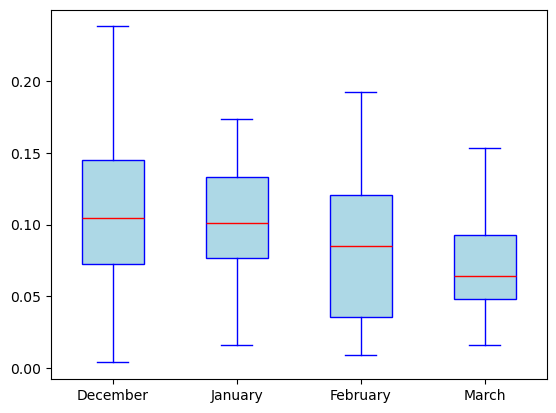

In [101]:
plt.boxplot(monthly_results, 
            positions=[1,2,3,4], 
            widths=0.5,
            patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            flierprops=dict(markerfacecolor='red', marker='o', markersize=5),
            showfliers=False
           )
plt.xticks([1,2,3,4], ['December', 'January', 'February', 'March'])


In [102]:
result_df.mean()

no_of_events             92.777778
length_of_winter        970.133333
percentage_of_events      9.563406
discrete_events          14.933333
dtype: object

In [59]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=result_df.index,
    y=result_df['percentage_of_events'],
    mode='lines+markers',
    name='Percentage of Events',
    line=dict(color='blue', width=2),
))
fig.update_layout(
    width=800,
    height=500,
    title='Percentage of Events by Water Year',
    xaxis_title='Water Year',
    yaxis_title='Percentage of Events (%)',
)

In [80]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=result_df.index,
    y=result_df['discrete_events'],
    mode='lines+markers',
    name='# of large events',
    line=dict(color='blue', width=2),
))
fig.update_layout(
    width=800,
    height=500,
    title='Modeled Number of large sublimation events using ERA5 reanalysis variables',
    xaxis_title='Water Year',
    yaxis_title='# of events',
)

# 13. Plot Reanalysis

In [48]:
def clippedcolorbar(CS, **kwargs):
    from matplotlib.cm import ScalarMappable
    from numpy import arange, floor, ceil
    fig = CS.get_figure()
    vmin = CS.get_clim()[0]
    vmax = CS.get_clim()[1]
    m = ScalarMappable(cmap=CS.get_cmap())
    m.set_array(CS.get_array())
    m.set_clim(CS.get_clim())
    step = CS.levels[1] - CS.levels[0]
    cliplower = CS.zmin<vmin
    clipupper = CS.zmax>vmax
    noextend = 'extend' in kwargs.keys() and kwargs['extend']=='neither'
    # set the colorbar boundaries
    boundaries = arange((floor(vmin/step)-1+1*(cliplower and noextend))*step, (ceil(vmax/step)+1-1*(clipupper and noextend))*step, step)
    kwargs['boundaries'] = boundaries
    # if the z-values are outside the colorbar range, add extend marker(s)
    # This behavior can be disabled by providing extend='neither' to the function call
    if not('extend' in kwargs.keys()) or kwargs['extend'] in ['min','max']:
        extend_min = cliplower or ( 'extend' in kwargs.keys() and kwargs['extend']=='min' )
        extend_max = clipupper or ( 'extend' in kwargs.keys() and kwargs['extend']=='max' )
        if extend_min and extend_max:
            kwargs['extend'] = 'both'
        elif extend_min:
            kwargs['extend'] = 'min'
        elif extend_max:
            kwargs['extend'] = 'max'
    return fig.colorbar(m, **kwargs)

In [49]:
# create Pillow writer object
metadata = dict(title='ERA5 700 hPa Temperature', artist='DLHogan')
writer = PillowWriter(fps=3, metadata=metadata,)

# Create the figure and basemap
fig = plt.figure(figsize=(6, 6))


# with writer.saving(fig, "temperature.gif", 100):
for i,t in enumerate(ds_subset_700['time'][10:11]):
    # clear the figure
    plt.clf()
    m = Basemap(projection='cyl', llcrnrlon=-128, llcrnrlat=23, urcrnrlon=-100, urcrnrlat=53, resolution='l')
    m.drawcoastlines(1)
    m.drawcountries()

    # Draw parallels and meridians
    parallels = np.arange(23, 53 + 0.25, 5)
    m.drawparallels(parallels, labels=[1, 0, 0, 0], linewidth=0.5)
    meridians = np.arange(-128, -100 + 0.25, 10)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], linewidth=0.5)
    m.drawstates()
    # Contour plot for temperature
    cbarticks=np.arange(0.0,30.0,2)
    cf = plt.contourf(ds_subset_700['longitude'], ds_subset_700['latitude'], (ds_subset_700['t'].sel(time=t).to_numpy() - ds_subset_700['dew_point'].sel(time=t).to_numpy()), cbarticks, cmap='coolwarm', vmin=0, vmax=30, extend='both')
    c = plt.contour(ds_subset_700['longitude'], ds_subset_700['latitude'], (ds_subset_700['t'].sel(time=t).to_numpy() - ds_subset_700['dew_point'].sel(time=t).to_numpy()), cbarticks, colors='k')
    cb = fig.colorbar(cf, orientation='horizontal', pad=0.05, label='Temperature (°C)')

    # add title of the time
    plt.title(f'700 hPa Temperature - {ds_subset_700["time"].sel(time=t).dt.strftime("%Y-%m-%d %H:%M").item()}')
    # Add barbs for wind, showing every 10th barb
    lon, lat = np.meshgrid(ds_subset_700['longitude'], ds_subset_700['latitude'])
    m.barbs(lon[::5, ::5], lat[::5, ::5], ds_subset_700['u'][i, ::5, ::5], ds_subset_700['v'][i, ::5, ::5], length=5, pivot='middle')
        
    
        # writer.grab_frame()
    

NameError: name 'ds_subset_700' is not defined

<Figure size 600x600 with 0 Axes>

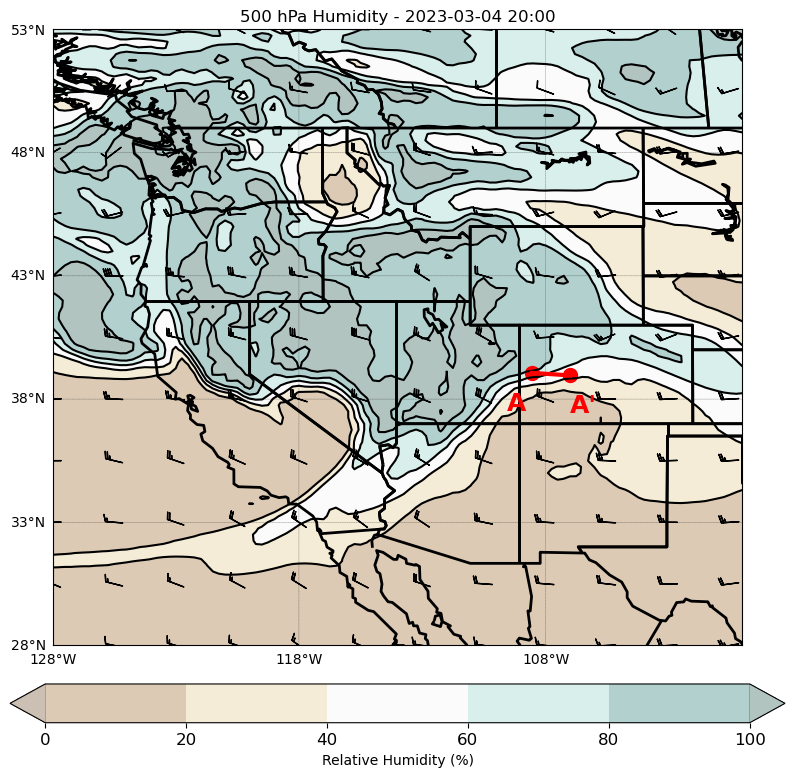

In [ ]:
# create Pillow writer object
metadata = dict(title='ERA5 500 hPa Temperature', artist='DLHogan')
writer = PillowWriter(fps=3, metadata=metadata,)

# Create the figure and basemap
fig = plt.figure(figsize=(10, 10))


# with writer.saving(fig, "relative_humidity.gif", 100):
for i,t in enumerate(ds_subset_700['time'][20:21]):
    # clear the figure
    plt.clf()
    m = Basemap(projection='cyl', llcrnrlon=-128, llcrnrlat=28, urcrnrlon=-100, urcrnrlat=53, resolution='l')
    m.drawcoastlines(linewidth=2)
    m.drawcountries(linewidth=2)

    # Draw parallels and meridians
    parallels = np.arange(23, 53 + 0.25, 5)
    m.drawparallels(parallels, labels=[1, 0, 0, 0], linewidth=0.25)
    meridians = np.arange(-128, -100 + 0.25, 10)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], linewidth=0.25)
    m.drawstates(linewidth=2)
    # Contour plot for temperature
    cbarticks=np.arange(0.0,100.0,10)
    cf = plt.contourf(ds_subset_700['longitude'], ds_subset_700['latitude'], (ds_subset_700['r'].sel(time=t).to_numpy()), cbarticks, cmap='BrBG', levels=np.arange(0,110,20), extend='both', alpha=0.3)
    c = plt.contour(ds_subset_700['longitude'], ds_subset_700['latitude'], (ds_subset_700['r'].sel(time=t).to_numpy()), cbarticks, levels=np.arange(0,110,20), colors='k')
    cb = fig.colorbar(cf, orientation='horizontal', pad=0.05, label='Relative Humidity (%)')
    cb.ax.tick_params(labelsize='large')
    
    # add line for the line and label A to A'
    x, y = line.xy
    m.plot(x, y, color='r', linewidth=3)
    m.scatter(gj.x, gj.y, color='r', s=100)
    m.scatter(gothic.x, gothic.y, color='r', s=100)
    plt.text(gj.x-1, gj.y-1.5, 'A', fontsize=18, color='r', fontweight='bold')
    plt.text(gothic.x, gothic.y-1.5, 'A\'', fontsize=18, color='r', fontweight='bold')

    # add title of the time
    plt.title(f'500 hPa Humidity - {ds_subset_700["time"].sel(time=t).dt.strftime("%Y-%m-%d %H:%M").item()}')
    # Add barbs for wind, showing every 10th barb
    lon, lat = np.meshgrid(ds_subset_700['longitude'], ds_subset_700['latitude'])
    m.barbs(lon[::10, ::10], lat[::10, ::10], ds_subset_700['u'][i, ::10, ::10], ds_subset_700['v'][i, ::10, ::10], length=5, pivot='middle')
    

    # writer.grab_frame()
    

# Next Process:
1) download NARR longterm mean data for u, v, q, temperature, height
2) download NARR data for 2022 and 2023. 
3) Calculate anomaly 